Authors:
    <br>Alejandro Alvarez (axa)
    <br>Brenda Palma (bpalmagu)

# <center>ML-Jokes: Collaborative Filtering </center>

## Setup

In [1]:
# Path to ml-jokes folder
import os
if os.getcwd().split('/')[-2] == 'ml-jokes': os.chdir('..')
print(f'Current directory: {os.getcwd()}')
assert set(['data', 'mljokes', 'environment.yml', 'nbs']) <= set(os.listdir()), \
    'Wrong path; go to ./heinz-95729-project/api/ml-jokes'

Current directory: /home/brendapalmag/eCommerce/heinz-95729-project/api/ml-jokes


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise import dump
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from mljokes.data import read_jokes, read_ratings, load_test_idx
from mljokes import cf_utils as cfu

## Data Prep

In [3]:
# Read jokes
jokes = read_jokes()

In [10]:
# Read and consolidate jester ratings
test_idx = load_test_idx()
ratings = read_ratings()
ratings['test_idx'] = test_idx

del test_idx

ratings.head(3)

,user_id,joke_id,rating,test_user,test_idx
0,0,1,99.0,0,0
1,0,2,99.0,0,0
2,0,3,99.0,0,0


In [12]:
# Filter out missing ratings (99.0)
unseen = ratings.loc[ratings['rating']==99]
ratings = ratings.loc[ratings['rating']!=99]
ratings.reset_index(inplace=True, drop=True)
ratings.sort_values(by=['user_id', 'joke_id'], ascending=True, inplace=True, ignore_index=True)
ratings.head(3)

,user_id,joke_id,rating,test_user,test_idx
0,0,5,-1.65,0,0
1,0,7,-0.78,0,0
2,0,8,6.89,0,0


## SVD Model

In [17]:
# Build custom dataset 
reader = Reader(rating_scale=(ratings.rating.min(), ratings.rating.max()))
data = Dataset.load_from_df(ratings[['user_id', 'joke_id', 'rating']], reader)

In [412]:
# Hyperparameter tuning
param_grid = {'lr_all': [0.002, 0.005], \
    'n_factors': [10, 15, 20, 30],\
        'biased': [True, False],\
            'reg_all': [0.02, 0.05]}

gs = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=3)
gs.fit(data)

# Best MAE score
print(gs.best_score['mae'])

# Combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

3.2880766368255827
{'lr_all': 0.002, 'n_factors': 10, 'biased': False, 'reg_all': 0.05}


In [20]:
# Train model with full train dataset
data = Dataset.load_from_df(ratings.loc[ratings['test_idx']==0,['user_id', 'joke_id', 'rating']], reader)
trainset = data.build_full_trainset()

model = gs.best_estimator['mae']
model.fit(trainset)


In [27]:
# Get MAE on test set
test_data = Dataset.load_from_df(ratings.loc[ratings['test_idx']==1,['user_id', 'joke_id', 'rating']], reader)
_, test_data = train_test_split(test_data, test_size=1.0)

predictions = model.test(test_data)
accuracy.mae(predictions)


MAE:  3.3316


3.331646376696592

In [28]:
# Save model
file_name = './results/cf_bestModel_mae'
dump.dump(file_name, algo=model, verbose=0)

## Get all predictions

In [35]:
all_ratings = cfu.get_all_ratings(model)
all_ratings.to_pickle('./results/cf_preds.pkl')

## Get Recommendations

In [19]:
# Load model
file_name = './results/cf_bestModel_mae'
_, model = dump.load(file_name)

In [38]:
# Choose user
user_id = 4493
unseen_by_user = unseen.values[unseen['user_id']==user_id, 1]
cfu.get_user_profile(model, ratings, jokes, user_id, 3, 10, unseen_by_user)

Top rated jokes
A man piloting a hot air balloon discovers he has wandered off course and is hopelessly lost. He descends to a lower altitude and locates a man down on the ground. He lowers the balloon further and shouts "Excuse me, can you tell me where I am?" The man below says: "Yes, you're in a hot air balloon, about 30 feet above this field." "You must work in Information Technology," says the balloonist. "Yes I do," replies the man. "And how did you know that?" "Well," says the balloonist, "what you told me is technically correct, but of no use to anyone." The man below says, "You must work in management." "I do," replies the balloonist, "how did you know?" "Well," says the man, "you don't know where you are, or where you're going, but you expect my immediate help. You're in the same position you were before we met, but now it's my fault!" 

One Sunday morning William burst into the living room and said, "Dad! Mom! I have some great news for you! I am getting married to the most 

/home/brendapalmag/anaconda3/envs/ecommerce_jokes/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


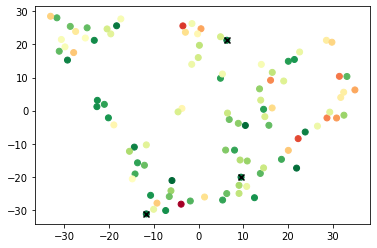

In [48]:
# Visualize joke-concept matrix with predicted ratings from selected user
joke_embeddings = cfu.generate_joke_embeddings(model, perplexity = 6, random_state = 3)
cfu.plot_user_preferences(model, joke_embeddings, user_id,unseen_by_user, n_recommended=3, mask_unseen=False)